## using yt's stretched grid functionality with zfp-compressed lofs-cm1 netcdf files

yt 4.1.0 includes improved handling of stretched grids (defined as grids with variable spacing in each dimension). Stretched grids are common in geoscience data and so it's useful to demonstrate in the context of the zfp-compressed lofs-cm1 netcdf files (see zfp_cm1_yt_demo.ipynb in this repository). 



In [19]:
import h5py 
import yt 
import hdf5plugin
from yt.sample_data.api import lookup_on_disk_data
import numpy as np


def get_widths(coord):
    # calculates the cell width from an array of observation points, preserving
    # the min/max of the ranges. 
    extrema = [coord.min(), coord.max()]
    
    # calculate edges of cells, preserving data min/max.
    edges = (coord[1:] +coord[0:-1])/2
    edges = np.concatenate([np.array([extrema[0]]), edges, np.array([extrema[1]])])                        
    wids = edges[1:] - edges[0:-1]
    return wids.astype(np.float64), extrema, edges
    
def load_cm1_stretched_in_memory(fn, fields = None):
    """ loads lofs-cm1 data on a single stretched grid """
    
    data_coords = ("zh", "yh", "xh")  # name in the netcdf file 
    yt_coord_name = ("z", "y", "x")  # internal yt name
    
    if fields is None:
        fields = ["dbz", "vortmag"]
        
    # first read in the data and global coordinates
    fn = str(lookup_on_disk_data(fn))
    data = {}    
    global_coord_info = {}  # store the x,y,z widths and ranges across the dataset
    with h5py.File(fn, "r") as handle:
        for dim, ytdim in zip(data_coords, yt_coord_name):
            global_coord_info[ytdim] = get_widths(handle[dim][:])
            
        for field in fields:
            data[field] = (handle[field][0,:], "")  # neglecting units here 
            
    
    # store the bounding box
    bbox = np.array([global_coord_info[dim][1] for dim in yt_coord_name])
    
    # store the cell widths
    cell_wids = [global_coord_info[dim][0] for dim in yt_coord_name]

    return yt.load_uniform_grid(data, data[fields[0]][0].shape, 
                                length_unit="km", 
                                geometry=("cartesian", yt_coord_name),
                                bbox=bbox, 
                                cell_widths=cell_wids)

In [20]:
ds = load_cm1_stretched_in_memory("cm1_zfp_compressed/mkow075-ens-db620.00790800.nc")

yt : [INFO     ] 2022-10-05 11:11:03,047 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-10-05 11:11:03,048 Parameters: domain_dimensions         = [ 232  996 1096]
yt : [INFO     ] 2022-10-05 11:11:03,050 Parameters: domain_left_edge          = [  0.0375     -29.88750076 -37.38750076]
yt : [INFO     ] 2022-10-05 11:11:03,052 Parameters: domain_right_edge         = [17.36249924 44.73749924 44.73749924]
yt : [INFO     ] 2022-10-05 11:11:03,053 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2022-10-05 11:11:05,182 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-05 11:11:05,183 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-05 11:11:05,184 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-05 11:11:05,185 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-05 11:11:05,193 Making a fixed resolution buffer of (('stream', 'dbz')) 800 by 800



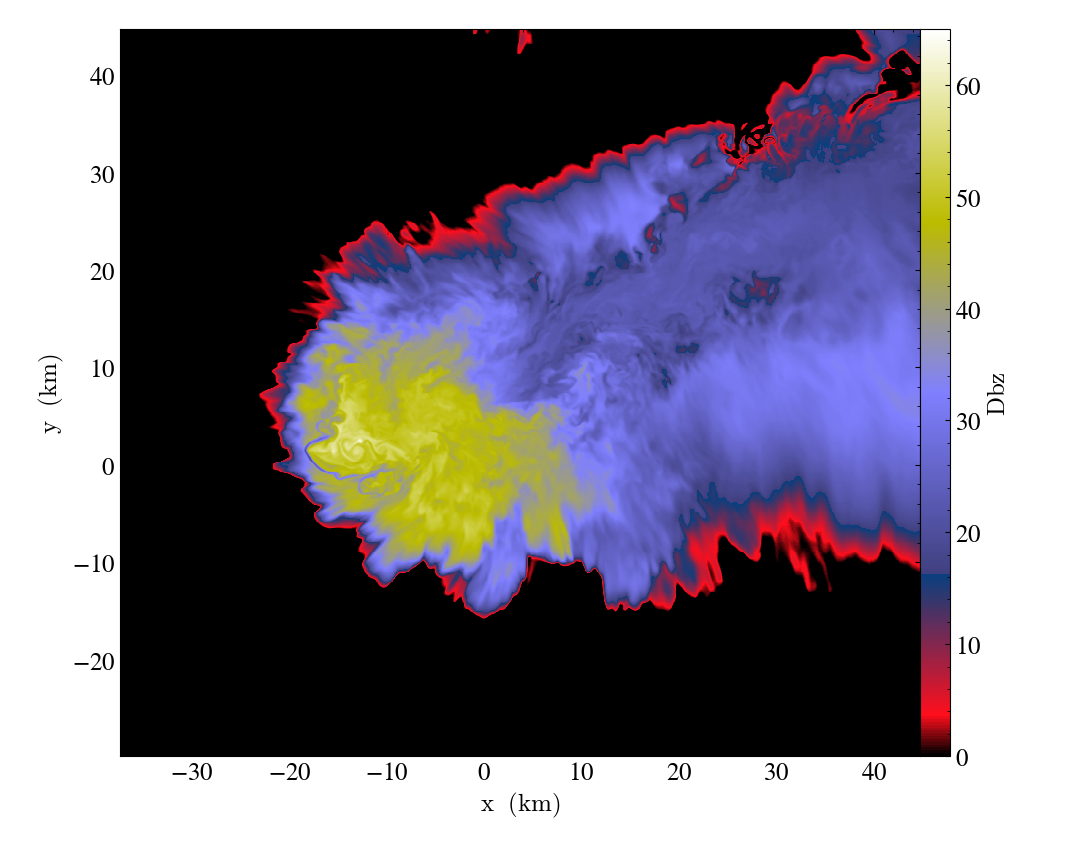

In [21]:
def set_cmap_prefs(yt_plot, field, cmap_name, cmap_limits):
    yt_plot.set_log(field, False)
    yt_plot.set_cmap(field, cmap_name)
    yt_plot.set_zlim(field, cmap_limits[0], cmap_limits[1])
    
field = ("stream", "dbz")
slc = yt.SlicePlot(ds, "z", field, origin="native")
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.show()

### stetched grids with a callable: a prototype

In [68]:
import h5py 
import yt 
import hdf5plugin
from yt.sample_data.api import lookup_on_disk_data
from yt.utilities.decompose import decompose_array, get_psize
from yt.utilities.logger import ytLogger as mylog
from typing import Optional, Union, List 
import numpy as np


def split_array_indices(shape, psize):
    """Split array into px*py*pz subarrays."""
    n_d = np.array(shape, dtype=np.int64)    
    left_edge_i = []
    right_edge_i = []
    shapes = []
    slices = []
    for i in range(psize[0]):
        for j in range(psize[1]):
            for k in range(psize[2]):
                piece = np.array((i, j, k), dtype=np.int64)
                lei = n_d * piece // psize
                rei = n_d * (piece + np.ones(3, dtype=np.int64)) // psize                
                left_edge_i.append(lei)
                right_edge_i.append(rei)
                shapes.append(rei - lei)
                slices.append(np.s_[lei[0] : rei[0], lei[1] : rei[1], lei[2] : rei[2]])

    return left_edge_i, right_edge_i, shapes, slices


def build_grids(fields, 
                handle,
                reader_function,
                global_coord_info,
                le_i, re_i, shapes, slices):

    grids = []
    coorder = global_coord_info["ordering"]
    ngrids = len(shapes)
    for igrid in range(ngrids):
        new_grid = {}
        for field in fields:
            # works:
            # raw_data = handle[field][0, 
            #                          le_i[igrid][0]:re_i[igrid][0], 
            #                          le_i[igrid][1]:re_i[igrid][1], 
            #                          le_i[igrid][2]:re_i[igrid][2]]
            # new_grid[field] = (raw_data, "")  # unitless for now
            
            # does not:
            new_grid[field] = (reader_function, "")  # unitless for now
            
        left_edge = []
        right_edge = []
        cell_widths = []
        for idim in range(3):
            dim = coorder[idim]
            wids, extema, edges = global_coord_info[dim]
            
            left_edge.append(edges[le_i[igrid][idim]])
            right_edge.append(edges[re_i[igrid][idim]])
            cell_widths.append(wids[le_i[igrid][idim]:re_i[igrid][idim]])
            
        new_grid["left_edge"] = tuple(left_edge)
        new_grid["right_edge"] = tuple(right_edge)
        new_grid["cell_widths"] = cell_widths
        new_grid["level"] = 0
        new_grid["dimensions"] = shapes[igrid]        
    
        grids.append(new_grid)
    return grids 

def load_stretched_stream_grids(grid_data, 
                         domain_dimensions,                                                                            
                         bbox=None,                          
                         length_unit = None,
                         mass_unit = None,
                         time_unit = None,
                         velocity_unit = None,
                         magnetic_unit = None,
                         sim_time=0.0,   
                         periodicity=(True, True, True),
                         geometry="cartesian",    
                         unit_system="cgs",
                         default_species_fields=None,
                         *,
                         parameters=None,
                         ):
    
    from yt.frontends.stream.data_structures import (
        StreamDataset,
        StreamDictFieldHandler,
        StreamHandler,
    )
    from yt.frontends.stream.definitions import process_data, set_particle_types
    from yt.utilities.lib.misc_utilities import get_box_grids_level

    domain_dimensions = np.array(domain_dimensions)
    ngrids = len(grid_data)
    if bbox is None:
        bbox = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], "float64")
    domain_left_edge = np.array(bbox[:, 0], "float64")
    domain_right_edge = np.array(bbox[:, 1], "float64")
    grid_levels = np.zeros((ngrids, 1), dtype="int32")
    grid_left_edges = np.zeros((ngrids, 3), dtype="float64")
    grid_right_edges = np.zeros((ngrids, 3), dtype="float64")
    cell_widths = []
    grid_dimensions = np.zeros((ngrids, 3), dtype="int32")
    number_of_particles = np.zeros((ngrids, 1), dtype="int64")
    parent_ids = np.zeros(ngrids, dtype="int64") - 1
    sfh = StreamDictFieldHandler()
    for i, g in enumerate(grid_data):
        grid_left_edges[i, :] = g.pop("left_edge")
        grid_right_edges[i, :] = g.pop("right_edge")
        grid_dimensions[i, :] = g.pop("dimensions")
        grid_levels[i, :] = g.pop("level")
        cell_widths.append(g.pop("cell_widths"))
        if any(grid_levels[i,:]) > 0:
            raise NotImplementedError("cannot have tiled stretched grids with refinement level > 0")
        field_units, data, n_particles = process_data(
            g, grid_dims=tuple(grid_dimensions[i, :])
        )
        number_of_particles[i, :] = n_particles
        sfh[i] = data

    # We now reconstruct our parent ids, so that our particle assignment can
    # proceed.
    mask = np.empty(ngrids, dtype="int32")
    for gi in range(ngrids):
        get_box_grids_level(
            grid_left_edges[gi, :],
            grid_right_edges[gi, :],
            grid_levels[gi] + 1,
            grid_left_edges,
            grid_right_edges,
            grid_levels,
            mask,
        )
        ids = np.where(mask.astype("bool"))
        for ci in ids:
            parent_ids[ci] = gi

    
    if length_unit is None:
        length_unit = "code_length"
    if mass_unit is None:
        mass_unit = "code_mass"
    if time_unit is None:
        time_unit = "code_time"
    if velocity_unit is None:
        velocity_unit = "code_velocity"
    if magnetic_unit is None:
        magnetic_unit = "code_magnetic"

    particle_types = {}

    for grid in sfh.values():
        particle_types.update(set_particle_types(grid))

    handler = StreamHandler(
        grid_left_edges,
        grid_right_edges,
        grid_dimensions,
        grid_levels,
        parent_ids,
        number_of_particles,
        np.zeros(ngrids).reshape((ngrids, 1)),
        sfh,
        field_units,
        (length_unit, mass_unit, time_unit, velocity_unit, magnetic_unit),
        particle_types=particle_types,
        periodicity=periodicity,
        parameters=parameters,
        cell_widths = cell_widths, 
    )

    handler.name = "AMRGridData"
    handler.domain_left_edge = domain_left_edge
    handler.domain_right_edge = domain_right_edge
    handler.refine_by = 2  # only level 0 allowed, this will not be used.
    if np.all(domain_dimensions[1:] == 1):
        dimensionality = 1
    elif domain_dimensions[2] == 1:
        dimensionality = 2
    else:
        dimensionality = 3
    handler.dimensionality = dimensionality
    handler.domain_dimensions = domain_dimensions
    handler.simulation_time = sim_time
    handler.cosmology_simulation = 0

    sds = StreamDataset(
        handler,
        geometry=geometry,
        unit_system=unit_system,
        default_species_fields=default_species_fields,
    )
    return sds


In [69]:


def load_cm1_zfp_stretched_multigrid(
    fn: Union[str, "os.PathLike[str]"],
    root_node: Optional[str] = "/",
    fields: Optional[List[str]] = None,
    bbox: np.ndarray = None,
    nchunks: int = 0,
):
    data_coords = ("zh", "yh", "xh")  # name in the netcdf file 
    yt_coord_name = ("z", "y", "x")  # internal yt name
    coord_ordering = {idim:dim for idim, dim in enumerate(yt_coord_name)}
      

    def _read_data(handle, root_node):
        def _reader(grid, field_name):
            ftype, fname = field_name
            si = grid.get_global_startindex()
            ei = si + grid.ActiveDimensions
            return handle[root_node][fname][0, si[0] : ei[0], si[1] : ei[1], si[2] : ei[2]]

        return _reader

    fn = str(lookup_on_disk_data(fn))
    handle = h5py.File(fn, "r")
    
    if bbox is None:
        bbox = []
        dbz_shape = []
        for dim in data_coords: 
            bbox.append([np.min(handle[dim]), np.max(handle[dim])])
        bbox = np.array(bbox)
        mylog.info(f"calculated bounding box, {bbox}")        
    
    reader = _read_data(handle, root_node)
    
    if fields is None:
        fields = ["dbz", "vortmag"]
                
    shape = handle[root_node][fields[0]].shape[1:]
        
    # existing does not end up working .... problem with slices
    if nchunks <= 0:
        # We apply a pretty simple heuristic here.  We don't want more than
        # about 64^3 zones per chunk.  So ...
        full_size = np.prod(shape)
        nchunks = full_size // (64**3)
        mylog.info("Auto-guessing %s chunks from a size of %s", nchunks, full_size)

    # get arrays of left, right edges
    psize = get_psize(np.array(shape), nchunks)
    left_edge_i, right_edge_i, shapes, slices = split_array_indices(shape, psize)
    
    # store the global coordinate info
    global_coord_info = {}  # store the x,y,z widths and ranges across the dataset
    for dim, ytdim in zip(data_coords, yt_coord_name):
        global_coord_info[ytdim] = get_widths(handle[dim][:])
    global_coord_info["ordering"] = coord_ordering
    
    # set up the grids
    grid_data = build_grids(
                    fields,
                    handle,
                    reader,                
                    global_coord_info,
                    left_edge_i, 
                    right_edge_i,
                    shapes, 
                    slices)
          
    return load_stretched_stream_grids(grid_data, shape, length_unit="km", bbox=bbox, geometry=("cartesian", yt_coord_name))


In [70]:
ds = load_cm1_zfp_stretched_multigrid("cm1_zfp_compressed/mkow075-ens-db620.00790800.nc", nchunks=50)

yt : [INFO     ] 2022-10-05 11:39:08,178 calculated bounding box, [[ 3.75000e-02  1.73625e+01]
 [-2.98875e+01  4.47375e+01]
 [-3.73875e+01  4.47375e+01]]
yt : [INFO     ] 2022-10-05 11:39:08,290 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-10-05 11:39:08,292 Parameters: domain_dimensions         = [ 232  996 1096]
yt : [INFO     ] 2022-10-05 11:39:08,293 Parameters: domain_left_edge          = [  0.0375     -29.88750076 -37.38750076]
yt : [INFO     ] 2022-10-05 11:39:08,297 Parameters: domain_right_edge         = [17.36249924 44.73749924 44.73749924]
yt : [INFO     ] 2022-10-05 11:39:08,299 Parameters: cosmological_simulation   = 0


In [71]:
ad = ds.all_data()
ad["stream", "dbz"].shape

IndexError: boolean index did not match indexed array along dimension 2; dimension is 218 but corresponding boolean dimension is 220

yt : [INFO     ] 2022-10-05 11:35:15,077 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-05 11:35:15,078 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-05 11:35:15,081 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-05 11:35:15,082 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-05 11:35:15,088 Making a fixed resolution buffer of (('stream', 'dbz')) 800 by 800



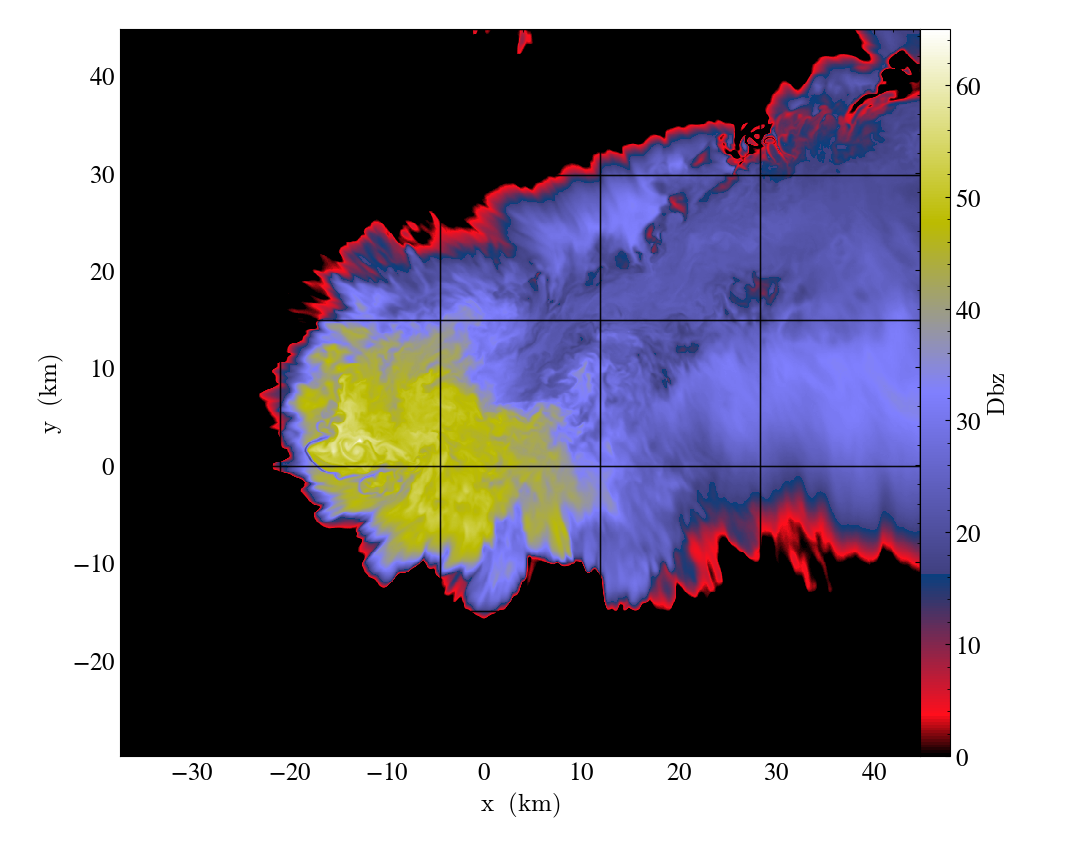

In [56]:
field = ("stream", "dbz")
slc = yt.SlicePlot(ds, "z", field, origin="native")
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.annotate_grids()
slc.show()

In [76]:
fn = str(lookup_on_disk_data("cm1_zfp_compressed/mkow075-ens-db620.00790800.nc"))
handle = h5py.File(fn, "r")
raw_data=handle["dbz"][0,:]
shape = handle["dbz"].shape[1:]
nchunks=50
psize = get_psize(np.array(shape), nchunks)
left_edge_i, right_edge_i, shapes, slices = split_array_indices(shape, psize)

In [82]:
for sl in slices:
    _ = raw_data[sl].shape

yt : [INFO     ] 2022-10-05 11:12:08,620 calculated bounding box, [[ 3.75000e-02  1.73625e+01]
 [-2.98875e+01  4.47375e+01]
 [-3.73875e+01  4.47375e+01]]
yt : [INFO     ] 2022-10-05 11:12:08,622 Auto-guessing 966 chunks from a size of 253254912
yt : [INFO     ] 2022-10-05 11:12:08,836 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-10-05 11:12:08,837 Parameters: domain_dimensions         = [ 232  996 1096]
yt : [INFO     ] 2022-10-05 11:12:08,839 Parameters: domain_left_edge          = [  0.0375     -29.88750076 -37.38750076]
yt : [INFO     ] 2022-10-05 11:12:08,841 Parameters: domain_right_edge         = [17.36249924 44.73749924 44.73749924]
yt : [INFO     ] 2022-10-05 11:12:08,842 Parameters: cosmological_simulation   = 0


IndexError: boolean index did not match indexed array along dimension 2; dimension is 36 but corresponding boolean dimension is 48